In [1]:
import os, sys
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from util import basic
print("Done!")

Done!


In [2]:
import seaborn as sns

In [3]:
import sys, os
import numpy as np
import gzip

## Load benchmark dataset 

In [4]:
seq_convert = {'N':'0', 'A':'1', 'C':'2', 'G':'3', 'T':'4'}

In [5]:
seq_convert_rev = {'0': 'N', '1':'A', '2':'C', '3':'G', '4':'T'}

In [6]:
start_codon = ["ATG", "GTG", "TTG", "CTG", "ATT", "ATC"]

In [7]:
folder_name = (
    '/mnt/scratch7/hirak/Attention4DNASeqRepresentation/dataset/Predict_Bothways_pos_neg_example'
)

In [8]:
full_genome_file = (
    '/mnt/scratch7/hirak/Attention4DNASeqRepresentation/dataset/Predict_Bothways/forward_genes/forward_batch_0_0.gz'
)

In [25]:
max_data_size = 1527294

def read_input_file(file_path, label=-1):
    x_data = []
    y_data = []

    file_read = open(file_path, "r")
    for line in file_read:
        data = [int(i) for i in line.strip()]
        x_data.append(data)
        y_data.append(label)
        #print(x_data[-1], y_data[-1])
        if len(x_data) == max_data_size:
            break
    file_read.close()
    print("Sequences Read: ", len(x_data))
    return np.array(x_data), np.array(y_data)

In [26]:
root_dir = "/mnt/scratch7/hirak/"
x_data_pos_full, y_data_pos_full = read_input_file(os.path.join(root_dir, "Attention4DNASeqRepresentation/dataset/gene_range_start_codon.txt"), 1)

original_neg_intergenic_data, original_neg_intergenic_label = read_input_file(os.path.join(root_dir, "Attention4DNASeqRepresentation/dataset/intragenic_start_codon.txt"), 0)
original_neg_coding_data, original_neg_coding_label = read_input_file(os.path.join(root_dir, "Attention4DNASeqRepresentation/dataset/coding_start_codon.txt"), 0)

x_data_neg_full = np.concatenate((original_neg_coding_data, original_neg_intergenic_data))
y_data_neg_full = np.concatenate((original_neg_coding_label, original_neg_intergenic_label))


Sequences Read:  1527294
Sequences Read:  1527294
Sequences Read:  1527294


In [9]:
def construct_postive_negative_samples(file_name):
    with gzip.open(file_name, 'rt', encoding='utf-8') as fp:
        seq_name = fp.readline().rstrip()
        seq_str = fp.readline().strip()
        coding_region = fp.readline().strip()
        encoded_gene = fp.readline().strip()
    
    print(len(seq_str))
        
    negative_samples = []
    positive_samples = []
    for i in range(len(seq_str)-100):
        sample = seq_str[i:i+101]
        convert = ''.join([seq_convert[sample[k]] for k in range(len(sample))])
        middle_codon = i + 49
        codon = seq_str[ middle_codon : middle_codon + 3 ]
        labelled_codon = encoded_gene[middle_codon:middle_codon+3]
        coding = coding_region[middle_codon]

        if ((codon in start_codon) and (labelled_codon == "111")):
            positive_samples += [list(convert)]
        elif ((codon in start_codon) and (coding == "0")):
            negative_samples += [list(convert)]
            
    return (positive_samples, negative_samples)

In [10]:
positive_samples, negative_samples = construct_postive_negative_samples(full_genome_file)

4641652


In [71]:
len(positive_samples), len(negative_samples)

(2012, 268728)

In [72]:
#positive_samples[0]

In [133]:
map(str,np.zeros(shape=(5000,101)))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [124]:
with open(os.path.join(folder_name,'forward_batch_0_0_positive.txt'), 'w') as fp:
    for s in positive_samples:
        fp.write('{}\n'.format(''.join(s)))
        
with open(os.path.join(folder_name,'forward_batch_0_0_negative.txt'), 'w') as fp:
    for s in negative_samples:
        fp.write('{}\n'.format(''.join(s)))

## Load the model 

In [76]:
def PCA(data, k=2):
    # preprocess the data
    # X = torch.from_numpy(data)
    pca_vec = []
    for X in data:
    
        X_mean = torch.mean(X,0)
        X = X - X_mean.expand_as(X)

        # svd
        U,S,V = torch.svd(torch.t(X))
        pca_vec += [torch.mm(X,U[:,:k]).squeeze().detach().numpy()]
    
    return pca_vec

In [52]:
class AttnDecoderRNN(nn.Module):#corrected batch faster
    #(self, time_steps, embedding_dim, hidden_dim, vocab_size, tagset_size, mini_batch)
    def __init__(self, vocab_size, embedding_dim, \
                 hidden_dim, device, batch_size=100, debug=1, \
                 tagset_size=1, time_steps=101):
        super(AttnDecoderRNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.time_steps = time_steps
        self.hidden_dim = hidden_dim
        self.minibatch_size = batch_size
        self.dropout_p = 0.25
        self.tagset_size = tagset_size
        self.hidden = self.init_hidden()
        self.hidden_bi = self.init_hidden(bidirectional=True)
        self.debug = debug
        self.device = device 

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_one = nn.LSTM(embedding_dim, int(hidden_dim/2), batch_first=True, bidirectional=True)
        self.dropout_one = nn.Dropout(self.dropout_p)
        self.lstm_two = nn.LSTM(hidden_dim, int(hidden_dim/2), batch_first=True, bidirectional=True)
        self.dropout_two = nn.Dropout(self.dropout_p)
        self.lstm_three = nn.LSTM(hidden_dim, int(hidden_dim/2), batch_first=True, bidirectional=True)
        self.dropout_three = nn.Dropout(self.dropout_p)

        self.attn_array = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(time_steps)])
        
 	
        self.lstm_four = nn.LSTM(hidden_dim, int(hidden_dim/2), batch_first=True, bidirectional=True)
        self.dropout_seven = nn.Dropout(0.4)
        
        self.lstm_five = nn.LSTM(hidden_dim, int(hidden_dim/2), batch_first=True, bidirectional=True)
        self.dropout_eight = nn.Dropout(0.4)
        

        """
        self.attn_combine = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        self.linear = nn.Linear(hidden_dim, 1)
        #embedding_dim*time_steps
        """

        self.hidden2tag_one = nn.Linear(hidden_dim*time_steps, 512)
        self.dropout_four = nn.Dropout(self.dropout_p)
        self.hidden2tag_two = nn.Linear(512, 128)
        self.dropout_five = nn.Dropout(self.dropout_p)
        self.hidden2tag_three = nn.Linear(128, 64)
        self.dropout_six = nn.Dropout(self.dropout_p)

        self.output = nn.Linear(64, tagset_size)

    def forward(self, input):
        init_embed = self.embedding(input)
        #embedded = init_embed.permute(1, 0, 2)
        if self.debug == 1:
            print("Embedding Shape: ", init_embed.shape)

        lstm_out, self.hidden_one = self.lstm_one(init_embed, self.hidden_bi)
        lstm_out = self.dropout_one(lstm_out)
        lstm_out, self.hidden_two = self.lstm_two(lstm_out, self.hidden_bi)
        lstm_out = self.dropout_two(lstm_out)
        lstm_out, self.hidden_three = self.lstm_three(lstm_out, self.hidden_bi)
        lstm_out = self.dropout_three(lstm_out)
        
        attn_applied = None
        #"""
        lstm_permute = lstm_out.permute(1, 0, 2)
        if self.debug == 1:
            print("LSTM Out Shape: ", lstm_permute.shape)

        attention = [self.attn_array[i](lstm_permute[i][:]) for i in range(self.time_steps)]
        attention = torch.stack(attention)
        attention.to(device)
        
        attention = attention.permute(1, 0, 2)
        if self.debug == 1:
            print("Attention Shape: ", attention.shape)
        
        attn_weights = F.softmax(attention, dim=2)
        #attn_weights = attn_weights.view(self.minibatch_size, self.time_steps, 1)
        if self.debug == 1:
            print("Softmax Shape: ", attn_weights.shape)
        
        #attn_applied = init_embed
        attn_applied = attn_weights * init_embed
        
        # potential lstm 
        if self.debug == 1:
            print("Attention Applied Shape: ", attn_applied.shape)
        
        lstm_out, self.hidden_one = self.lstm_four(attn_applied, self.hidden_bi)
        lstm_out = self.dropout_seven(lstm_out)
        if self.debug == 1:
            print("LSTM out: ", lstm_out.shape)
        
        lstm_out, self.hidden_two = self.lstm_five(lstm_out, self.hidden_bi)
        lstm_out = self.dropout_eight(lstm_out)    
        
        #attn_applied = attn_applied.view(self.minibatch_size, self.time_steps, -1)
        #attn_applied = torch.sum(attn_applied, dim=1)
        #output = F.relu(attn_applied)

        # lstm_out = attn_applied.contiguous().view(self.minibatch_size, -1)
        #"""
        
        #lstm_out = attn_applied.contiguous().view(self.minibatch_size, -1)
        lstm_out = lstm_out.contiguous().view(self.minibatch_size, -1)
        if self.debug == 1:
            print("LSTM Output Shape: ", lstm_out.shape)


        dense_out = self.hidden2tag_one(lstm_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_four(dense_out[:])

        dense_out = self.hidden2tag_two(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_five(dense_out[:])

        dense_out = self.hidden2tag_three(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_six(dense_out[:])

        tag_space = self.output(dense_out[:])
        #print(tag_space.shape)
        #tag_scores = F.sigmoid(tag_space)
        #tag_scores = F.softmax(tag_space, dim=1)
        #print(tag_scores.shape)
        return tag_space, attn_applied

    def init_hidden(self, bidirectional = False):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        if(bidirectional):
            return (torch.zeros(2, self.minibatch_size, int(self.hidden_dim/2), device = device),
                    torch.zeros(2, self.minibatch_size, int(self.hidden_dim/2), device = device))
        else:
            return (torch.zeros(1, self.minibatch_size, self.hidden_dim, device = device),
                    torch.zeros(1, self.minibatch_size, self.hidden_dim, device = device))

In [ ]:
# the_model.load_state_dict(torch.load(PATH))

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
batch_size = 5000
model = AttnDecoderRNN(5, 32, 32, device, batch_size=batch_size, debug=0)
#model = model.cuda()
model.to(device)

model.load_state_dict(
    torch.load(
      "/mnt/scratch7/hirak/Attention4DNASeqRepresentation/models/pytorch_model.param",
    map_location='cpu'
    )
   
)

cpu


In [54]:
model.eval()

AttnDecoderRNN(
  (embedding): Embedding(5, 32)
  (lstm_one): LSTM(32, 16, batch_first=True, bidirectional=True)
  (dropout_one): Dropout(p=0.25)
  (lstm_two): LSTM(32, 16, batch_first=True, bidirectional=True)
  (dropout_two): Dropout(p=0.25)
  (lstm_three): LSTM(32, 16, batch_first=True, bidirectional=True)
  (dropout_three): Dropout(p=0.25)
  (attn_array): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): Linear(in_featur

In [63]:
positive_sample_padded = np.concatenate([np.array(positive_samples), np.zeros((3000, 101)).astype(int)])

In [64]:
X_positive = torch.from_numpy(np.array(positive_sample_padded[:5000]).astype(int))
X_negative = torch.from_numpy(np.array(negative_samples[:5000]).astype(int))

#X_positive = torch.from_numpy(x_data_pos_full[:5000].astype(int))
#X_negative = torch.from_numpy(x_data_neg_full[:5000].astype(int))

In [65]:
tag_space_pos, attn_applied_pos = model(X_positive)

In [66]:
tag_space_neg, attn_applied_neg = model(X_negative)

In [58]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(F.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    
    return acc

In [67]:
positive_target = torch.from_numpy(np.ones(5000).reshape(5000,1).astype(np.int))

In [68]:
negative_target = torch.from_numpy(np.zeros(5000).reshape(5000,1).astype(np.int))

In [69]:
binary_accuracy(tag_space_pos[:2012].flatten(), positive_target[:2012].float().flatten())

/home/hirak/miniconda2/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1380: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.9916)

In [70]:
binary_accuracy(tag_space_neg[:5000].flatten(), negative_target[:5000].float().flatten())

/home/hirak/miniconda2/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1380: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.7824)

(array([ 10.,  30., 157., 299., 417., 508., 391., 166.,  28.,   6.]),
 array([-2.5856419 , -0.69373167,  1.1981785 ,  3.0900886 ,  4.981999  ,
         6.873909  ,  8.76582   , 10.657729  , 12.54964   , 14.441549  ,
        16.33346   ], dtype=float32),
 <a list of 10 Patch objects>)

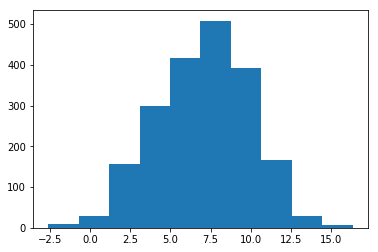

In [73]:
plt.hist(tag_space_pos[:2012].flatten().detach().numpy())

(array([   7.,   19.,   94.,  375.,  855., 1288., 1227.,  812.,  288.,
          35.]), array([-31.712965  , -27.206863  , -22.700762  , -18.194658  ,
        -13.688557  ,  -9.182455  ,  -4.676353  ,  -0.17025109,
          4.3358507 ,   8.841953  ,  13.348055  ], dtype=float32), <a list of 10 Patch objects>)

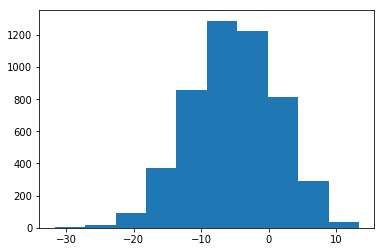

In [74]:
plt.hist(tag_space_neg.flatten().detach().numpy())

In [77]:
pca_attn_pos = PCA(attn_applied_pos, 1)
pca_attn_neg = PCA(attn_applied_neg, 1)

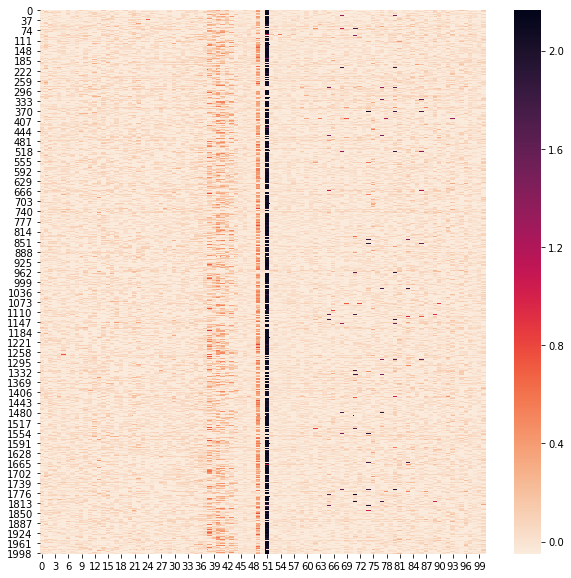

In [110]:
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.cm.rocket_r
sns.heatmap(np.array(pca_attn_pos[:2000]),
            ax = ax, 
            annot=False,
                 fmt=".3f",
    
                 vmin=-0.05,
                 cmap = cmap)

In [79]:
from Bio.Seq import Seq
from Bio import motifs

In [80]:
weblogo_seq = [Seq(''.join([seq_convert_rev[k] for k in a])) for a in np.array(positive_samples[:2000])]

In [98]:
promoter = [weblogo_seq[i][39:45] for i in range(0,2000)]

In [99]:
sorted(promoter)

[Seq('AAAAAA'),
 Seq('AAAAAC'),
 Seq('AAAAAT'),
 Seq('AAAAAT'),
 Seq('AAAAAT'),
 Seq('AAAAAT'),
 Seq('AAAACC'),
 Seq('AAAAGA'),
 Seq('AAAAGA'),
 Seq('AAAAGA'),
 Seq('AAAAGT'),
 Seq('AAAAGT'),
 Seq('AAAAGT'),
 Seq('AAAATG'),
 Seq('AAACAG'),
 Seq('AAACAT'),
 Seq('AAACGC'),
 Seq('AAACTA'),
 Seq('AAACTC'),
 Seq('AAAGAA'),
 Seq('AAAGAT'),
 Seq('AAAGCA'),
 Seq('AAAGCG'),
 Seq('AAAGGA'),
 Seq('AAAGGA'),
 Seq('AAAGGT'),
 Seq('AAAGGT'),
 Seq('AAAGTC'),
 Seq('AAATAC'),
 Seq('AAATAC'),
 Seq('AAATAT'),
 Seq('AAATCA'),
 Seq('AAATCT'),
 Seq('AAATGC'),
 Seq('AAATGG'),
 Seq('AAATTA'),
 Seq('AAATTT'),
 Seq('AACAAA'),
 Seq('AACAAA'),
 Seq('AACAAA'),
 Seq('AACAAC'),
 Seq('AACAAT'),
 Seq('AACACG'),
 Seq('AACACT'),
 Seq('AACACT'),
 Seq('AACAGC'),
 Seq('AACAGC'),
 Seq('AACATA'),
 Seq('AACATA'),
 Seq('AACCGA'),
 Seq('AACCGT'),
 Seq('AACGCG'),
 Seq('AACGTA'),
 Seq('AACGTA'),
 Seq('AACTAA'),
 Seq('AACTCA'),
 Seq('AACTGG'),
 Seq('AAGAAA'),
 Seq('AAGAAA'),
 Seq('AAGAAC'),
 Seq('AAGAAG'),
 Seq('AAGACA'),
 Seq('AA

In [81]:
with open('weblogo.seq','w') as fp:
    for s in weblogo_seq:
        fp.write("{}\n".format(s))

In [100]:
m = motifs.create(promoter)

In [101]:
m.weblogo("mymotif_promoter.png")

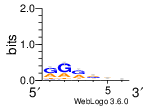

In [103]:
from IPython.display import Image
Image("mymotif_promoter.png")

/home/hirak/miniconda2/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


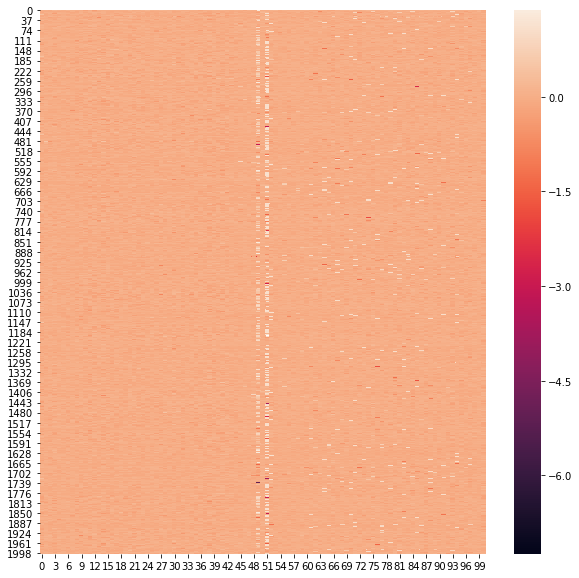

In [104]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(np.log(np.array(pca_attn_neg[:2000])+1),ax = ax)
